# Supplementary Material

> **"Background-dependent selection of genetic variation in heterogeneous populations"**

> Ignacio Vázquez-García, Francisco Salinas, Jing Li, Andrej Fischer, Benjamin Barré, Johan Hallin, Anders Bergström, Elisa Alonso-Pérez, Jonas Warringer, Ville Mustonen, Gianni Liti

## Supplementary Figures S9 and S10

This IPython notebook is provided for reproduction of Figures S9 and S10 of the paper. It can be viewed by copying its URL to nbviewer and it can be run by opening it in binder.

In [2]:
# load external dependencies
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.lines as lines
import matplotlib.patches as patches
import matplotlib.transforms as transforms
from matplotlib.ticker import FormatStrFormatter,MaxNLocator
%matplotlib inline

import numpy as np
import pandas as pd # (*) Pandas for data manipulation
from scipy import stats

import json, matplotlib
s = json.load( open("matplotlibrc.json") )
matplotlib.rcParams.update(s)

# load internal dependencies
import colors,config,plot,model,utils

# absolute file path for root directory of git repo
dir_repo = utils.get_git_path()
dir_data = dir_repo+"/data/"
dir_paper = dir_repo+"/manuscript/main/"
dir_supp = dir_repo+"/manuscript/supp/"

%load_ext autoreload
%autoreload 2

import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

## Data import

In [3]:
# load data
pheno_df = utils.load_data(dir_data+'pheno/genetic-constructs/pheno_constructs_norm.pickle')

# # filter out measurement replicates with >5% measurement error
# pheno_df['pct'] = pheno_df.groupby(['selection','environment','gene','background','genotype_long'])['growth_rate']\
# .apply(lambda x: (x-x.mean())/float(x.mean()))
# pheno_df = pheno_df[abs(pheno_df['pct'])<0.05]

pheno_df.head() # show dataframe header to stdout

,selection,environment,run,index,plate,row,column,group,population,background,...,time,assignment,isolate,gene,genotype_short,genotype_long,amino_acids,mating,auxotrophy,growth_rate
8000,HU,HU,1,282,0,5,42,parents,,WA,...,,,,RNR4,,WT,,MATa,ura3,-0.233068
7744,HU,HU,1,286,0,5,46,parents,,NA,...,,,,RNR4,,WT,,MATa,ura3,0.302884
8001,HU,HU,1,378,0,7,42,parents,,WA,...,,,,RNR4,,WT,,MATa,ura3,-0.251914
7745,HU,HU,1,382,0,7,46,parents,,NA,...,,,,RNR4,,WT,,MATa,ura3,0.350931
8002,HU,HU,1,434,0,9,2,parents,,WA,...,,,,RNR4,,WT,,MATα,lys2,-0.242307


## Figure S7 - Strategy for strain construction

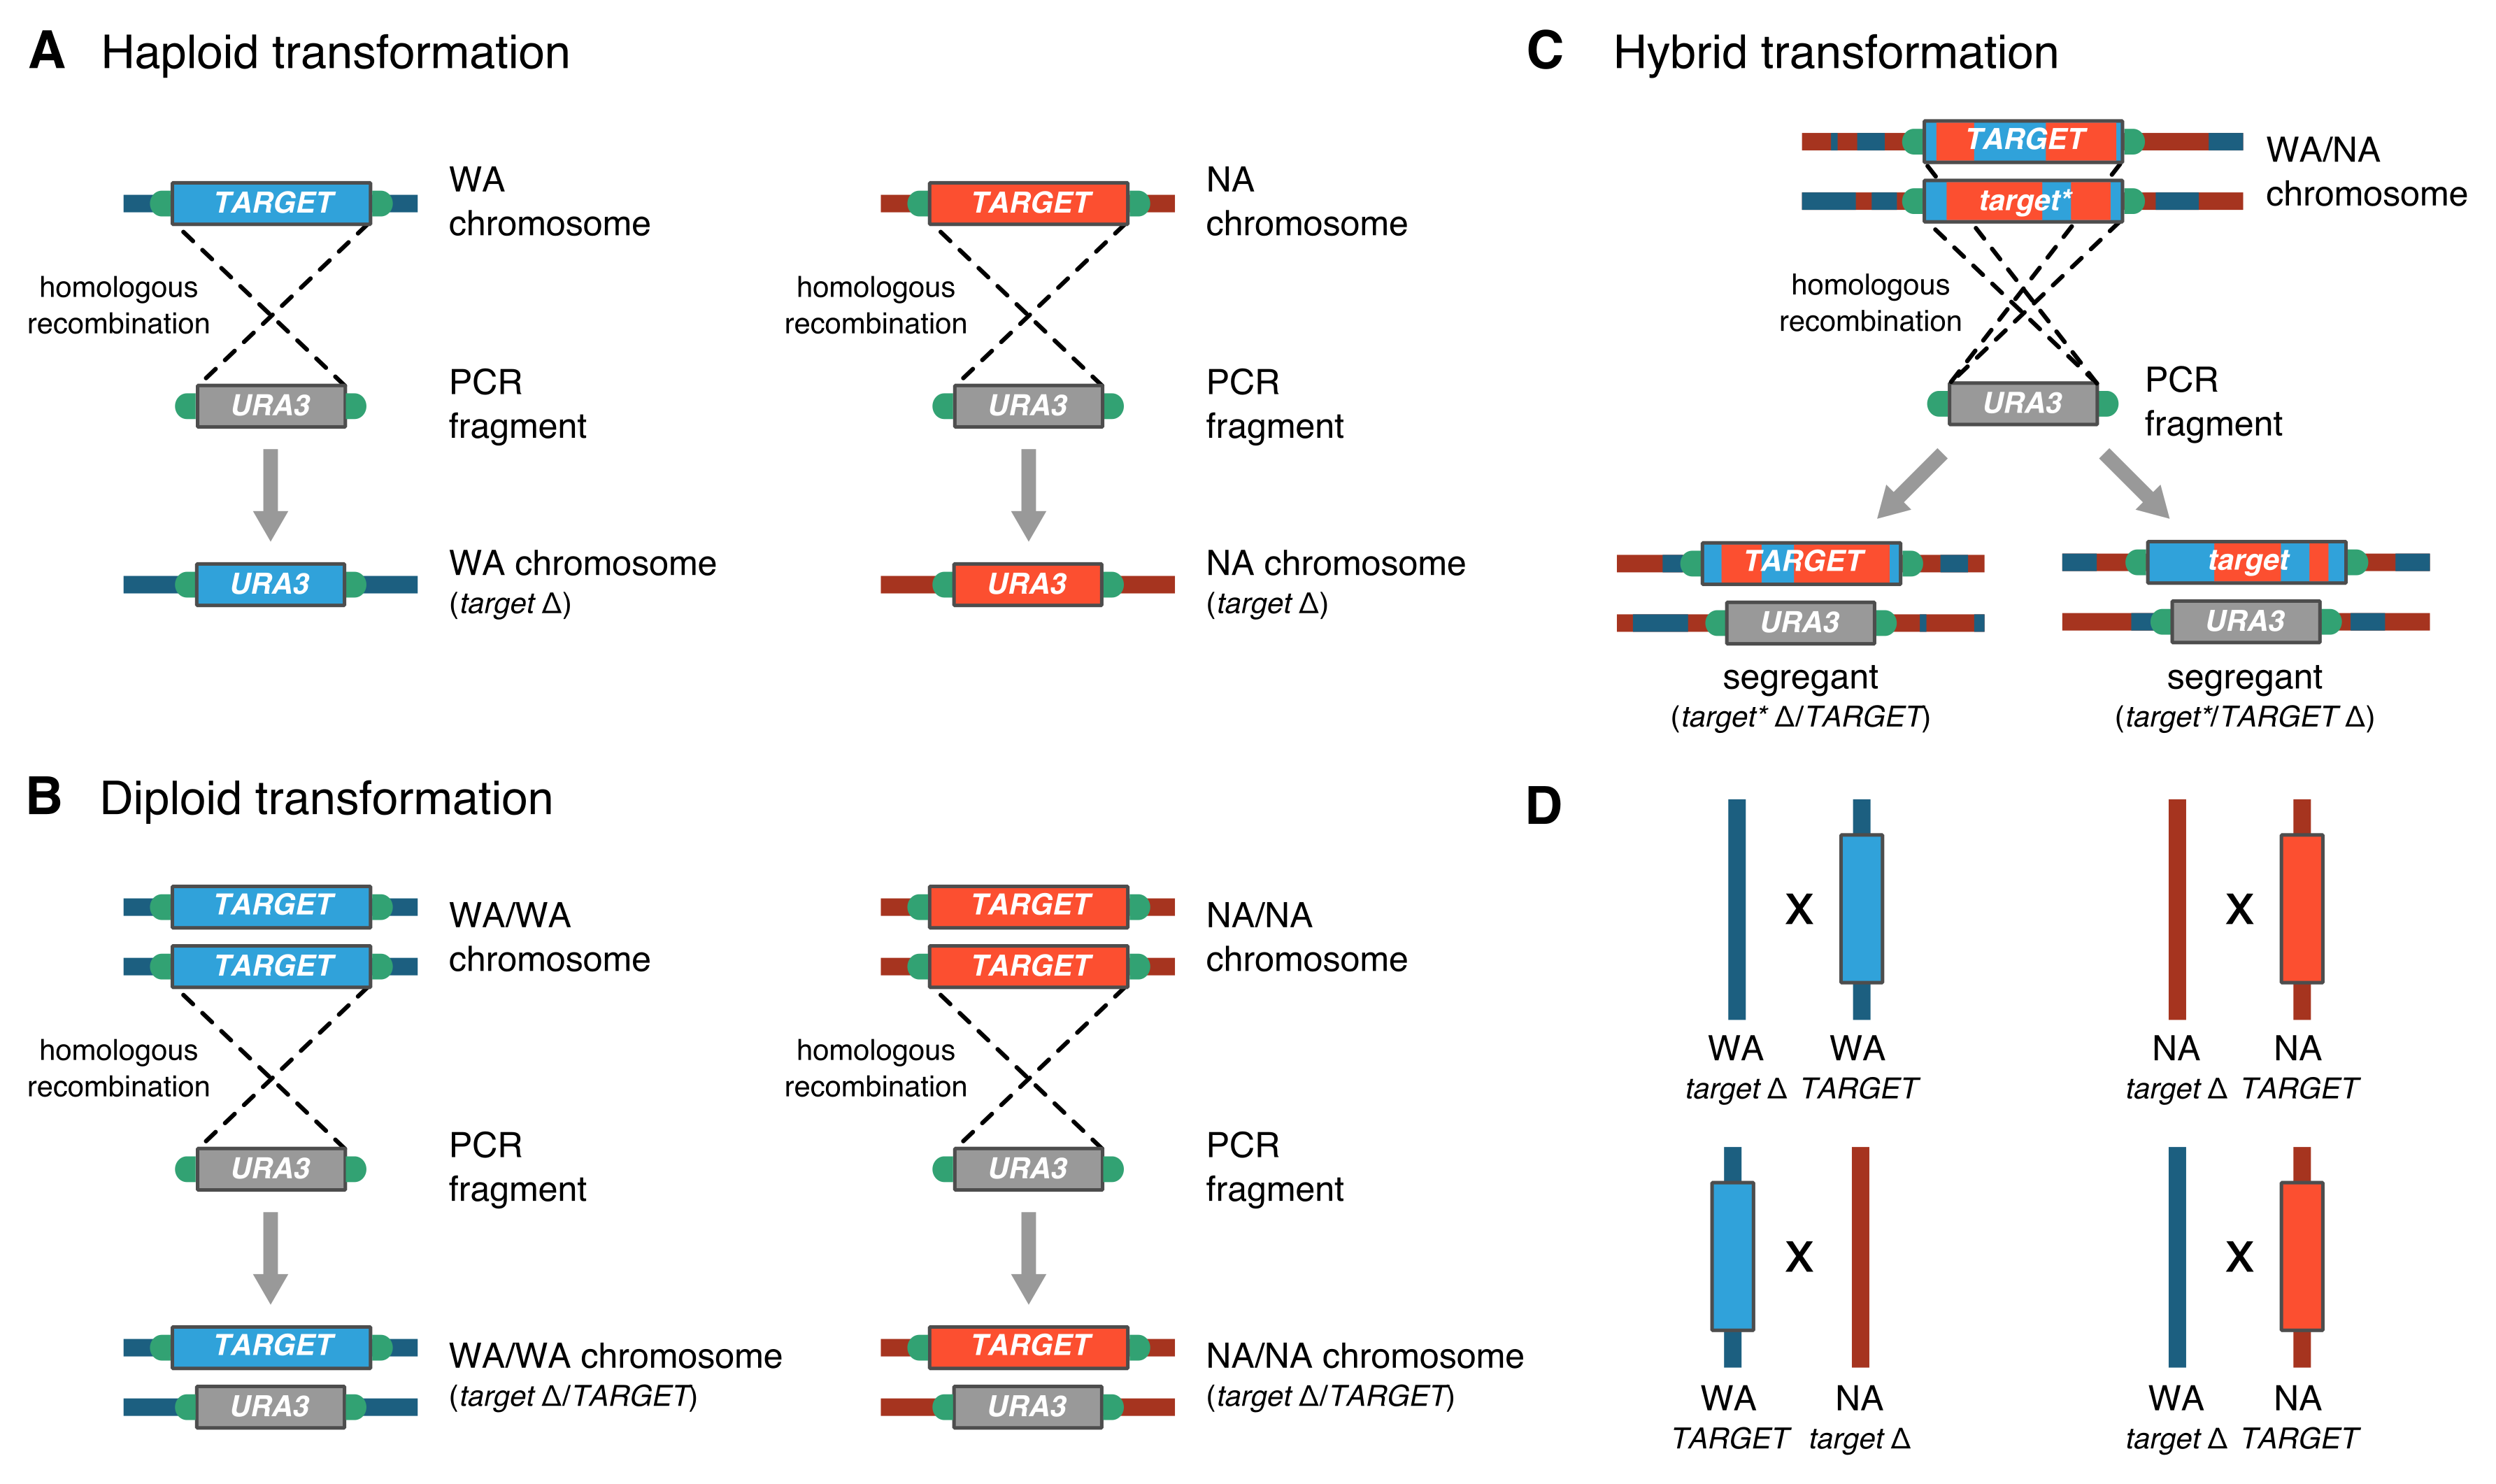

In [6]:
from IPython.display import Image
Image(filename=dir_supp+'figures/supp_figure_schematic_constructs/supp_figure_schematic_constructs_submission.png')

## Figure S8 and S9 - Validation tests for driver and passenger mutations

/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/pandas/core/indexing.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

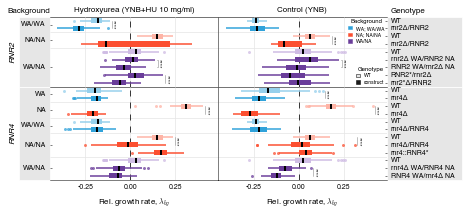

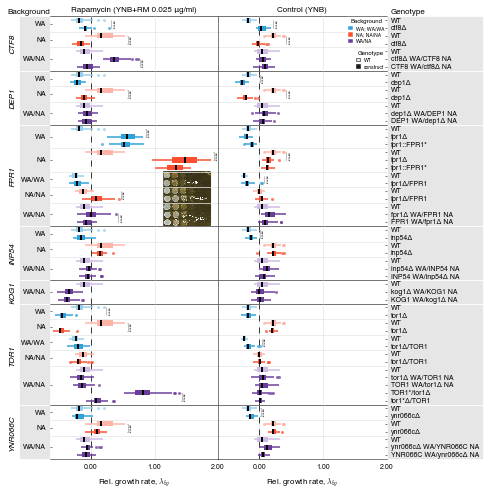

In [5]:
param = 'growth_rate'

shape = pd.DataFrame({k: 
 pd.pivot_table(x, values='growth_rate', columns=['background','genotype_long']).shape
 for k,x in pheno_df.groupby(['selection','environment','gene'])
})

for (ii, ((env_evo), gph1)) in enumerate(pheno_df.groupby(['selection'])):

    # remove NaNs
    gph1 = gph1[np.isfinite(gph1[param])]
    
    nrows=len(gph1.groupby(['background','gene','genotype_long']))
    ncols=len(gph1.groupby(['environment']))
            
    height, width = np.array([nrows*0.11, ncols*3], dtype=float)
    
    fig = plt.figure(figsize=(width, height), dpi=300)
    
    fig.subplots_adjust(left=0.07,bottom=0.01,right=0.85,top=0.99)

    grid = gridspec.GridSpec(1, 2, hspace=0., wspace=0.)
    
    gs = {}
        
    for (jj, ((env_test), gph2)) in enumerate(gph1.groupby(['environment'])):
        
        nrows = len(gph2['gene'].unique())
        ncols = 1
        height_ratios = shape[env_evo,env_test].values.squeeze()
        gs[env_test] = gridspec.GridSpecFromSubplotSpec(nrows, ncols, height_ratios=height_ratios, 
                                                        subplot_spec=grid[0,jj], hspace=0., wspace=0.)
    
        axes = {}
        
        for (kk, ((gene), gph3)) in enumerate(gph2.groupby('gene')):
                        
            gph3.loc[:,'rank_background'] = gph3['background'].map(config.construct_background['position'])
            gph3.loc[:,'rank_genotype'] = gph3['genotype_long'].map(config.construct_genotype[env_evo][gene])
            gph3.sort_values(['rank_background','rank_genotype'], 
                             ascending=[False,False], inplace=True)
      
            if kk == 0:
                axes[env_test] = plt.subplot(gs[env_test][kk])
                ax1 = axes[env_test]
                ax1.set_title(config.environment['long_label'][env_test], fontsize=8)
            else:
                ax1 = plt.subplot(gs[env_test][kk], sharex=axes[env_test])
            
            gph3 = gph3.set_index(['background','genotype_long'], append=True)[param]\
            .unstack(['background','genotype_long'])
            
            # boxplot
            bp = gph3.plot(ax=ax1, 
                           kind='box', 
                           widths=0.65, 
                           vert=False, 
                           return_type='dict',
                           labels=gph3.columns.get_level_values('background'))
            
            colors = [config.construct_background['color']['wt'][b] if g=='WT' \
                      else config.construct_background['color']['mut'][b] \
                      for b,g in zip(gph3.columns.get_level_values('background'),\
                                     gph3.columns.get_level_values('genotype_long'))]
            
            plot.boxplot_custom(bp, ax1, colors=colors, hatches=['']*30)
            
            for ll, x in enumerate(gph3.columns):
                
                if x in config.construct_tests[gene]:
                    
                    wt_data = gph3[config.construct_tests[gene][x]].dropna()
                    mut_data = gph3[x].dropna()
                    z_stat, p_val = stats.ranksums(wt_data,mut_data)
                                        
                    if p_val < 0.0001:
                    
                        x_min = min(wt_data.min(),mut_data.min())
                        x_max = max(wt_data.max(),mut_data.max())
                             
                        ax1.annotate('', xy=(x_max, ll+1), xycoords='data',
                                     xytext=(x_max, ll+2), textcoords='data',
                                     arrowprops=dict(arrowstyle="-", ec='#aaaaaa', linewidth=.75,
                                                     connectionstyle="bar,fraction=-0.3"))
                        ax1.annotate(utils.stars(p_val), 
                                     xy=((x_max+0.02 if env_evo=='HU' else x_max+0.04), ll+1.5), xycoords='data',
                                     ha='center', va='center', fontsize=6, rotation=270)
                        
            if jj==0:
                ax1.annotate(gene, 
                             xy=(-0.2, 0.5), xycoords=("axes fraction", "axes fraction"),
                             ha='right', va='center', annotation_clip=False, rotation=90, 
                             fontsize=8, fontstyle='italic')

            # reset ticks
            ax1.set_yticks([])
            ax1.set_yticklabels([])
            
            ax1.set_axisbelow(False)
            
            ### vertical ###
            ax1.xaxis.grid(ls="-", lw=.75, color="0.9", zorder=0)
            ax1.axvline(x=0., color='k', ls="--", lw=.75, zorder=3)
            
            ### horizontal ###
            
            ## background
            ystart, yend, ylabels = plot.set_custom_labels(gph3.columns, 0)
            
            # grid
            ygrid=[yst+1.5 for yst in list(set(ystart.values()))]
            [ax1.axhline(g, lw=.75, ls="-", color="0.9", zorder=2) for g in ygrid]
            
            # labels
            if jj==0:
                # tick labels
                ax1.set_yticks([y+1 for y in ylabels.values()], minor=True)
                ax1.set_yticklabels(ylabels.keys(), minor=True)
                ax1.get_yaxis().tick_left()
                if kk==0:
                    # axis label
                    ax1.set_ylabel('Background', transform=ax1.transAxes, rotation=0)
                    ax1.yaxis.set_label_coords(-0.125, 1.025)
            
            ## genotype
            # labels
            if jj==1:
                # tick labels
                ylabels = gph3.columns.get_level_values('genotype_long')
                ax1.set_yticks(np.arange(1, len(ylabels)+1), minor=True)
                ax1.set_yticklabels(['/'.join(y) if isinstance(y, tuple) else y for y in ylabels], minor=True)
                ax1.get_yaxis().tick_right()
                if kk==0:
                    # axis label
                    ax1.set_ylabel('Genotype', transform=ax1.transAxes, rotation=0)
                    ax1.yaxis.set_label_coords(1.125, 1.025)
            
            # set axes labels
            ax1.set_xlabel(r'Rel. growth rate, $\lambda_{bg}$', fontsize=10)
            
            if jj==1 and kk==0:
                wa_artist = patches.Rectangle((0,0), width=1, height=1, 
                                              color=config.construct_background['color']['mut']['WA'])
                na_artist = patches.Rectangle((0,0), width=1, height=1, 
                                              color=config.construct_background['color']['mut']['NA'])
                wana_artist = patches.Rectangle((0,0), width=1, height=1, 
                                                color=config.construct_background['color']['mut']['WA/NA'])

                leg1 = ax1.legend([wa_artist,na_artist,wana_artist], 
                                  ['WA; WA/WA','NA; NA/NA','WA/NA'], 
                                  ncol=1, loc='upper right',
                                  borderaxespad=0, handlelength=0.75, 
                                  prop={'size':5}, title='Background', 
                                  labelspacing=.32)

                wt_artist = patches.Rectangle((0,0), width=1, height=1, facecolor='0.9', edgecolor='k')
                construct_artist = patches.Rectangle((0,0), width=1, height=1, facecolor='0.1', edgecolor='k')

                leg2 = ax1.legend([wt_artist,construct_artist], 
                                  ['WT','construct'], 
                                  ncol=1, loc='lower right',
                                  borderaxespad=0, handlelength=0.75, 
                                  prop={'size':5}, title='Genotype', 
                                  labelspacing=.32)
                        
                ax1.add_artist(leg1)
        
                for leg in [leg1,leg2]:
                    plt.setp(leg.get_title(),fontsize=6)
                    leg.set_zorder(2)
                    leg.get_frame().set_edgecolor('none')
                    leg.get_frame().set_facecolor('w')
                    
            if env_evo=='RM' and env_test=='RM' and gene=='FPR1':
                transform = transforms.blended_transform_factory(ax1.transAxes, ax1.transData)
                x0, x1, y0, y1 = (1.125, 1.875, .5, 7.5)
                im = ax1.imshow(plt.imread(dir_supp+'figures/supp_figure_pheno_constructs/FPR1_LOH_inset.png'),
                                aspect='auto', extent=(x0, x1, y0, y1), transform=transform, zorder=1)
            
            transform = transforms.blended_transform_factory(ax1.transAxes, ax1.transAxes)
            if env_evo=='HU':
                ax1.set_xlim(-0.45,0.49)
                ax1.xaxis.set_major_locator( MaxNLocator(nbins = 4) )
                ax1.xaxis.set_minor_locator( MaxNLocator(nbins = 4) )
                ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
                if env_test=='HU':
                    ax1.spines['left'].set_visible(False)
                    ax1.spines['right'].set_visible(True)
                    patch = patches.Rectangle((-.25,0), width=.05, height=1,
                                              linewidth=.75, facecolor='0.9', edgecolor='w', 
                                              transform=transform, zorder=0)
                    patch = patches.Rectangle((-.18,0), width=.18, height=1,
                                              linewidth=.75, facecolor='0.9', edgecolor='w', 
                                              transform=transform, zorder=0)
                if env_test=='YNB':
                    ax1.spines['left'].set_visible(True)
                    ax1.spines['right'].set_visible(False)
                    patch = patches.Rectangle((1,0), width=.45, height=1,
                                              linewidth=.75, facecolor='0.9', edgecolor='w', 
                                              transform=transform, zorder=0)
            elif env_evo=='RM':
                ax1.set_xlim(-0.65,2)
                ax1.xaxis.set_major_locator( MaxNLocator(nbins = 3) )
                ax1.xaxis.set_minor_locator( MaxNLocator(nbins = 3) )
                ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
                if env_test=='RM':
                    ax1.spines['left'].set_visible(False)
                    ax1.spines['right'].set_visible(True)
                    patch = patches.Rectangle((-.18,0), width=.18, height=1,
                                              linewidth=.75, facecolor='0.9', edgecolor='w',  
                                              transform=transform, zorder=0)
                if env_test=='YNB':
                    ax1.spines['left'].set_visible(True)
                    ax1.spines['right'].set_visible(False)
                    patch = patches.Rectangle((1,0), width=.575, height=1,
                                              linewidth=.75, facecolor='0.9', edgecolor='w',  
                                              transform=transform, zorder=0)
                    patch.set_clip_on(False)
            ax1.add_patch(patch)
            patch.set_clip_on(False)

        # tweak axes
        for ax in fig.get_axes():
            ax.spines['top'].set_visible(True)
            ax.spines['bottom'].set_visible(True)
            
            ax.xaxis.label.set_size(8)
            ax.yaxis.label.set_size(8)
            ax.tick_params(axis='x', which='both', size=0, labelsize=7)
            ax.tick_params(axis='y', which='major', size=2, labelsize=7)
            ax.tick_params(axis='y', which='minor', size=2, labelsize=7)
            for sp in ax.spines.values():
                sp.set(color='k', linewidth=.5, linestyle='-')

    fig.savefig(dir_supp+'figures/supp_figure_pheno_constructs/supp_figure_pheno_constructs_%s.png' % env_evo, 
                dpi=300, bbox_inches='tight')
    fig.savefig(dir_supp+'figures/supp_figure_pheno_constructs/supp_figure_pheno_constructs_%s.svg' % env_evo, 
                dpi=300, bbox_inches='tight')
plt.show()

**Fig. S8:** Validation tests for driver mutations in hydroxyurea, measured in YNB+HU (left) and YNB (right). Growth rate measurements, $\lambda_{bg}$, are averaged over measurement replicates ($n = 64$) and grouped by candidate gene and by background of the construct, where the background $b$ can be WA, NA (haploid); WA/WA, NA/NA (diploid); WA/NA (hybrid), the genotype $g$ can be wild-type for the gene, deleted or hemizygous. Medians and 25%/75% percentiles across groups are shown, with medians as horizontal lines and outliers highlighted. The color of each of the boxes reflects the background, with WA and WA/WA (blue), NA and NA/NA (red) and WA/NA (purple). Lighter shades indicate WT control for that specific background and darker colors are the candidate strains. Using a non-parametric Wilcoxon rank-sum test, we compared deletion strains against their respective WT control and hemizygous strains against each other. Significance tests with a $p$-value below 0.0001 are highlighted.

**Fig. S9:** Validation tests for driver and passenger mutations in rapamycin, measured in YNB+RM (left) and YNB (right). Growth rate measurements, $\lambda_{bg}$, are averaged over measurement replicates ($n = 64$) and grouped by candidate gene and by background of the construct, where the background $b$ can be WA, NA (haploid); WA/WA, NA/NA (diploid); WA/NA (hybrid), the genotype $g$ can be wild-type for the gene, deleted or hemizygous. Medians and 25%/75% percentiles across groups are shown, with medians as horizontal lines and outliers highlighted. The color of each of the boxes reflects the background, with WA and WA/WA (blue), NA and NA/NA (red) and WA/NA (purple). Lighter shades indicate WT control for that specific background and darker colours are the candidate strains. Using a non-parametric Wilcoxon rank-sum test, we compared deletion strains against their respective WT control and hemizygous strains against each other. Significance tests with a $p$-value below 0.0001 are highlighted. Visual inspection of *FPR1* heterozygous deletions using a spot assay (inset) manifests the immediate loss of the wild-type allele by LOH -- validated by colony Sanger sequencing.

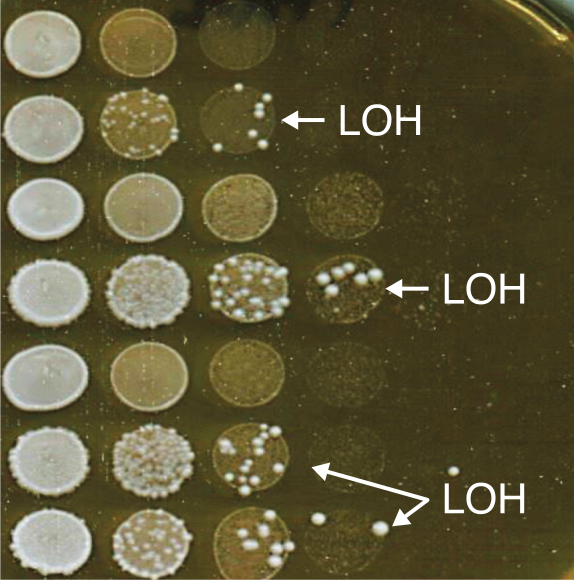

In [14]:
from IPython.display import Image
Image(filename=dir_supp+'figures/supp_figure_pheno_constructs/FPR1_LOH_inset.png')